In [10]:
import sys
sys.path.append('..')

from src.data_loader import download_stock_data, get_data_info
from src.strategy import calculate_sma, generate_signals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14,7)


In [11]:
ticker = "COALINDIA.NS"
df = download_stock_data(ticker, period ="5y", interval ="1d")

if df is not None:
    print(f" Downloading {ticker} stock data...")
    print(f"period: {df.index[0].date()} to {df.index[-1].date()}")
else:
    print("Data download failed")
    



Succesfully downloaded 1237 rows of data

Date range: 2021-02-01 to 2026-01-30
period: 2021-02-01 to 2026-01-30


In [12]:
short_window = 10
long_window = 50

df_sma = calculate_sma(df, short_window, long_window)

df_sma[['Close', f'SMA_{short_window}', f'SMA_{long_window}']].tail(10)

Calculated SMA 10 and SMA 50


,Close,SMA_10,SMA_50
Date,,,
2026-01-16 00:00:00+05:30,431.000000,428.635001,394.078000
2026-01-19 00:00:00+05:30,430.149994,428.904999,395.161000
2026-01-20 00:00:00+05:30,415.299988,427.729999,395.840000
2026-01-21 00:00:00+05:30,414.049988,425.969998,396.465000
2026-01-22 00:00:00+05:30,423.200012,425.764999,397.199000
2026-01-23 00:00:00+05:30,418.399994,425.769998,397.903000
2026-01-27 00:00:00+05:30,422.899994,424.829999,398.622000
2026-01-28 00:00:00+05:30,444.049988,426.344998,399.745999
2026-01-29 00:00:00+05:30,455.750000,428.699997,401.181999


In [13]:
df_signals = generate_signals(df_sma)

df_signals[['Close', f'SMA_{short_window}', f'SMA_{long_window}', 'Signal']].tail(10)

Buy signals:17
Sell signals:16


,Close,SMA_10,SMA_50,Signal
Date,,,,
2026-01-16 00:00:00+05:30,431.000000,428.635001,394.078000,0.0
2026-01-19 00:00:00+05:30,430.149994,428.904999,395.161000,0.0
2026-01-20 00:00:00+05:30,415.299988,427.729999,395.840000,0.0
2026-01-21 00:00:00+05:30,414.049988,425.969998,396.465000,0.0
2026-01-22 00:00:00+05:30,423.200012,425.764999,397.199000,0.0
2026-01-23 00:00:00+05:30,418.399994,425.769998,397.903000,0.0
2026-01-27 00:00:00+05:30,422.899994,424.829999,398.622000,0.0
2026-01-28 00:00:00+05:30,444.049988,426.344998,399.745999,0.0
2026-01-29 00:00:00+05:30,455.750000,428.699997,401.181999,0.0


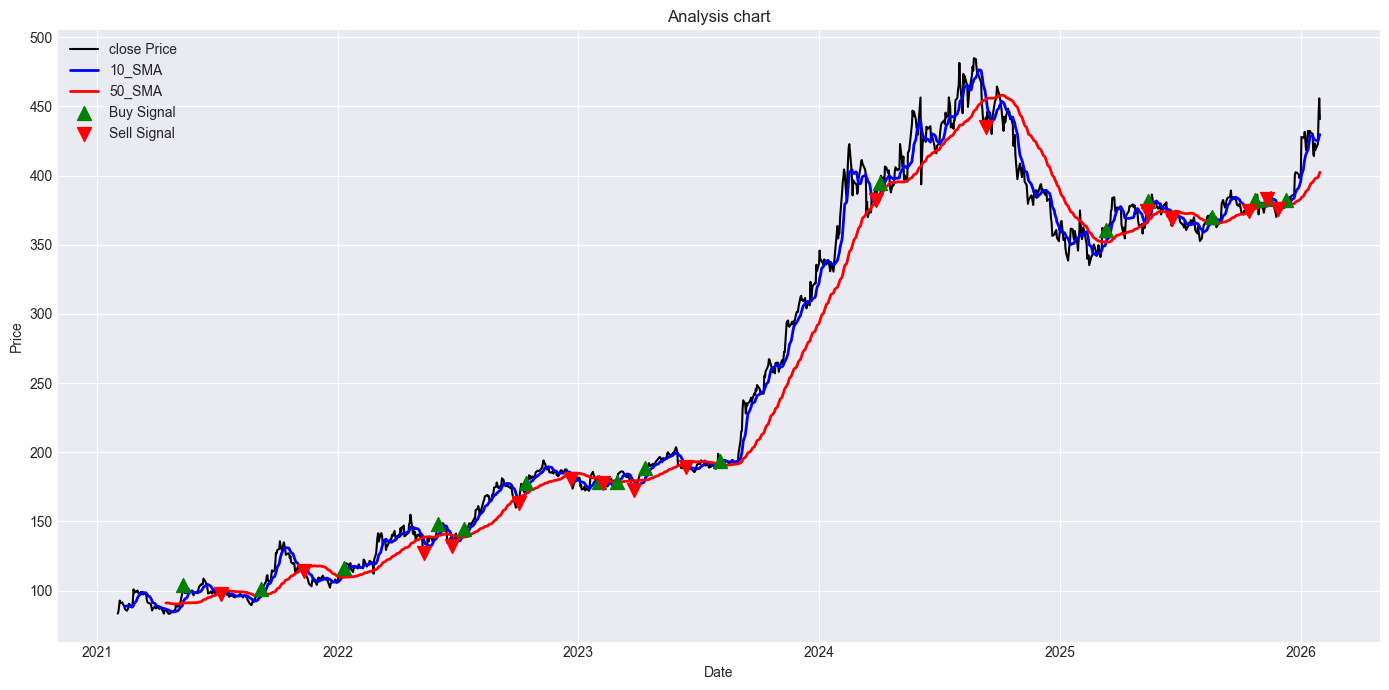

In [14]:
fig, ax = plt.subplots(figsize = (14,7))

ax.plot(df_signals['Close'], linewidth =1.5, label = 'close Price', color ='black')
ax.plot(df_signals[f'SMA_{short_window}'], linewidth = 2, label = f'{short_window}_SMA', color = 'blue')
ax.plot(df_signals[f'SMA_{long_window}'], linewidth = 2, label = f'{long_window}_SMA', color = 'red')

buy_signals = df_signals[df_signals['Signal'] == 2]
sell_signals = df_signals[df_signals['Signal']==-2]

ax.scatter(buy_signals.index, buy_signals['Close'], marker= '^',color = 'green', s= 100, label = 'Buy Signal', zorder = 5)
ax.scatter(sell_signals.index, sell_signals['Close'], marker = 'v', color = 'red', s = 100, zorder =5, label = 'Sell Signal')
ax.set_title("Analysis chart")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
plt.tight_layout()
plt.show()

In [15]:
def backtest_strategy(df_signals, initial_capital = 100000):
    
    df_backtest = df_signals.copy()
    df_backtest['Daily_Return'] = df_backtest['Close'].pct_change()
    df_backtest['Strategy_Return'] =df_backtest['Daily_Return']*df_backtest['Position'].shift(1)
    
    df_backtest['Cummulative_Market_Returns'] = (1 + df_backtest['Daily_Return']).cumprod() 
    df_backtest['Cummulative_Strategy_Returns'] = (1 + df_backtest['Strategy_Return']).cumprod()
    
    df_backtest['Market_Value'] = df_backtest['Cummulative_Market_Returns']*initial_capital
    df_backtest['Strategy_Value'] = df_backtest['Cummulative_Strategy_Returns']*initial_capital
    
    df_backtest.fillna({'Market_Value': initial_capital, 'Strategy_Value': initial_capital}, inplace=True)
    
    return df_backtest

df_backtest = backtest_strategy(df_signals)
print("Backtest Completed")



Backtest Completed


In [16]:
def calculate_metrics(df_backtest, initial_capital = 100000, years = 5):
    
    final_market_value =  df_backtest['Market_Value'].iloc[-1]
    final_strategy_value = df_backtest['Strategy_Value'].iloc[-1]
    
    market_return = ((final_market_value - initial_capital) / initial_capital)*100
    strategy_return = (( final_strategy_value - initial_capital)/ initial_capital)*100
    
    market_annual = ((final_market_value/initial_capital)**(1/years) -1)*100
    strategy_annual = ((final_strategy_value/initial_capital)**(1/years) -1)*100
    
    num_trades = len(df_backtest[df_backtest['Signal'] !=0])
    
    print("ENHANCED STRATEGY METRICS")
    
    print(f"Initial Capital: {initial_capital}")
    print(f"Final Market Value: {final_market_value:,.2f}")
    print(f"Total Market Return: {market_return:,.2f}%")
    print(f"Annualized Market Return: {market_annual:,.2f}%")
    
    print("\n")
    
    print(f"Initial Capital: {initial_capital}")
    print(f"Final Strategy Value: {final_strategy_value:,.2f}")
    print(f"Total Strategy Return: {strategy_return:,.2f}%")
    print(f"Annualized Strategy Return: {strategy_annual:,.2f}%")
    
    print("\n Comparision:")
    
    diff = final_strategy_value - final_market_value
    diff_pct = strategy_return - market_return
    
    if diff > 0:
        print(f"The strategy outperformed the market by {diff:,.2f} ({diff_pct:,.2f}%)")
    else:
        print(f"The strategy underperformed the market by {abs(diff):,.2f} ({abs(diff_pct):,.2f}%)")
        
    print(f"\nNumber of trades = {num_trades}")
    
    return {
        'final_market_value': final_market_value,
        'final_strategy_value': final_strategy_value,
        'market_return': market_return,
        'strategy_return': strategy_return,
        'market_annual': market_annual,
        'strategy_annual': strategy_annual,
        'num_trades': num_trades,
        'diff': diff,
        'diff_pct': diff_pct
    }
    
metrics = calculate_metrics(df_backtest, initial_capital=100000, years=5)

    
        

ENHANCED STRATEGY METRICS
Initial Capital: 100000
Final Market Value: 528,639.84
Total Market Return: 428.64%
Annualized Market Return: 39.52%


Initial Capital: 100000
Final Strategy Value: 137,200.33
Total Strategy Return: 37.20%
Annualized Strategy Return: 6.53%

 Comparision:
The strategy underperformed the market by 391,439.51 (391.44%)

Number of trades = 34
